# Scale-Dependent Modifications to Power Spectrum Multipoles

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Import the appropriate packages.

In [2]:
import glob
import os
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math
from astropy.constants import c
from astropy.cosmology import Planck15
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import LinearPower, Planck15 as Planck_15
from scipy.ndimage import gaussian_filter1d

from conf import PATHOUT
from horizonground.clustering_modification import (
    non_gaussianity_correction_factor,
    relativistic_correction_factor,
    standard_kaiser_factor,
)

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

model = np.random.choice(["PLE_model"])  # "PLE_model", "hybrid_model"
threshold = "-25.0"  # "-22.0", "-25.0"

print("Selected: {}, magnitude limit {}".format(model, threshold))

publication_dir = PATHOUT/"publication"/model

Selected: PLE_model, magnitude limit -25.0


In [3]:
FIDUCIAL_LINEAR_BIAS = lambda z: 1.2 / Planck_15.scale_independent_growth_factor(z)
FIDUCIAL_WAVENUMBERS = 1.e-3
FIDUCIAL_NON_GAUSSNIANTY = 1.

## Relativistic correction quantiles

In [4]:
chain_files = glob.glob("/".join([
    str(publication_dir), "dense_points", "correction", "relcrct_z*m{}*".format(threshold)
]))

In [5]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [6]:
dense_redshifts = []

gz_quantiles = defaultdict(list)
for chain_file in sorted(chain_files):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        distilled = chain_data['distill/chain'][()]
        gz_square_q = corner.quantile(np.square(distilled), q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        gz_quantiles[sigma_level].append(np.sqrt(gz_square_q[sigma_level_idx]))

Separate the high redshift part and the low redshift partat the pivot redshift.

In [7]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in evolution_bias_quantiles:
        del evolution_bias_quantiles[sigma_level][discontinuity_pos]
        del magnification_bias_quantiles[sigma_level][discontinuity_pos]

low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Multipole Modifications

In [8]:
monopole_RSD = np.asarray([
    standard_kaiser_factor(0, FIDUCIAL_LINEAR_BIAS(z), z, cosmo=Planck_15) 
    for z in dense_redshifts
])

quadrupole_RSD = np.asarray([
    standard_kaiser_factor(2, FIDUCIAL_LINEAR_BIAS(z), z, cosmo=Planck_15) 
    for z in dense_redshifts
])

In [9]:
monopole_PNG = np.asarray([
    non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, 0, FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS(z), z, 
        cosmo=Planck_15, tracer_p=1.6
    ) 
    for z in dense_redshifts
])

quadrupole_PNG = np.asarray([
    non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, 2, FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS(z), z, 
        cosmo=Planck_15, tracer_p=1.6
    ) 
    for z in dense_redshifts
])

In [10]:
monopole_GR = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 0, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[0])
])

monopole_GR_lower = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 0, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[-2])
])

monopole_GR_upper = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 0, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[2])
])

quadrupole_GR = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 2, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[0])
])

quadrupole_GR_lower = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 2, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[-2])
])

quadrupole_GR_upper = np.asarray([
    relativistic_correction_factor(
        FIDUCIAL_WAVENUMBERS, 2, z, 
        correction_value=gz, cosmo=Planck_15
    )
    for z, gz in zip(dense_redshifts, gz_quantiles[2])
])

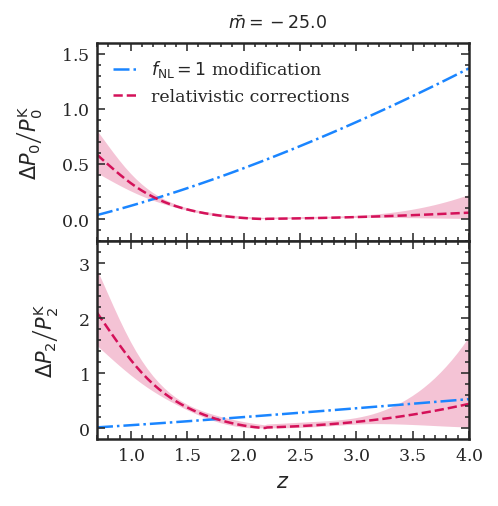

In [11]:
ALPHA = 0.25
if model == 'PLE_model':
    SMOOTH = 0.01
elif model == 'hybrid_model':
    SMOOTH = 0.01

fig = plt.figure("scale-dependent modifications", figsize=(3.2, 3.5), dpi=150)

monopole = plt.subplot2grid((2, 1), (0, 0))

monopole.plot(
    dense_redshifts, monopole_PNG / monopole_RSD,
    ls='-.', c='#1A85FF', zorder=0, label=r"$f_\mathrm{NL} = 1$ modification"
)
monopole.plot(
    dense_redshifts, monopole_GR / monopole_RSD,
    ls='--', c='#D41159', zorder=0, label="relativistic corrections"
)
monopole.fill_between(
    dense_redshifts, 
    monopole_GR_lower / monopole_RSD, monopole_GR_upper / monopole_RSD,
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-1
)

monopole.legend(handlelength=1.4, loc='upper left')
monopole.tick_params(axis='x', which='both', labelbottom=False)
monopole.xaxis.set_minor_locator(AutoMinorLocator())
monopole.yaxis.set_minor_locator(AutoMinorLocator())
monopole.set_xlim(min(dense_redshifts), max(dense_redshifts))
monopole.set_ylim(-0.2, 1.6)
monopole.set_ylabel(r"$\Delta P_0\left/P_0^\mathrm{K}\right.$", labelpad=8)

quadrupole = plt.subplot2grid((2, 1), (1, 0), sharex=monopole)

quadrupole.plot(
    dense_redshifts, quadrupole_PNG / quadrupole_RSD,
    ls='-.', c='#1A85FF', zorder=0
)
quadrupole.plot(
    dense_redshifts, gaussian_filter1d(quadrupole_GR / quadrupole_RSD, SMOOTH, mode='nearest'),
    ls='--', c='#D41159', zorder=0
)
quadrupole.fill_between(
    dense_redshifts, 
    gaussian_filter1d(quadrupole_GR_lower / quadrupole_RSD, SMOOTH, mode='nearest'), 
    gaussian_filter1d(quadrupole_GR_upper / quadrupole_RSD, SMOOTH, mode='nearest'),
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-1
)

quadrupole.yaxis.set_minor_locator(AutoMinorLocator())
quadrupole.set_ylim(-0.2, 3.4)
quadrupole.set_xlabel(r"$z$")
quadrupole.set_ylabel(r"$\Delta P_2\left/P_2^\mathrm{K}\right.$", labelpad=8)

fig.suptitle(r"$\bar{{m}} = {}$".format(threshold), fontsize='small', y=0.935)
fig.savefig(publication_dir/"gallery"/"scale-dependent_modifications_m{}.pdf".format(threshold))